#### Import data set

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('train.csv')

#### Split data into train and test datasets

In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
print('train: %s' % len(train))
print('test: %s' % len(test))

train: 33892
test: 8473


#### Vectorize queries

In [3]:
# sample query data
list(train['query'][:10])

['Batman arkham',
 'Need for speed',
 'dead island',
 'xbox',
 'Mw3',
 'top spin',
 'batman arkham city',
 'borderlands',
 'Madden 12',
 'Modern warfare 3']

In [4]:
import nltk
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

vectorizer = TfidfVectorizer(tokenizer=textblob_tokenizer, stop_words='english')
tfidf = vectorizer.fit_transform(list(train['query']))

[nltk_data] Downloading package punkt to /Users/wm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yo

#### Find best K for clustering

In [5]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = {}
k = 500
while k <= 3500:
    model = KMeans(n_clusters=k, n_init=1)
    model.fit(tfidf)
    distorsions[k] = model.inertia_
    k += 500

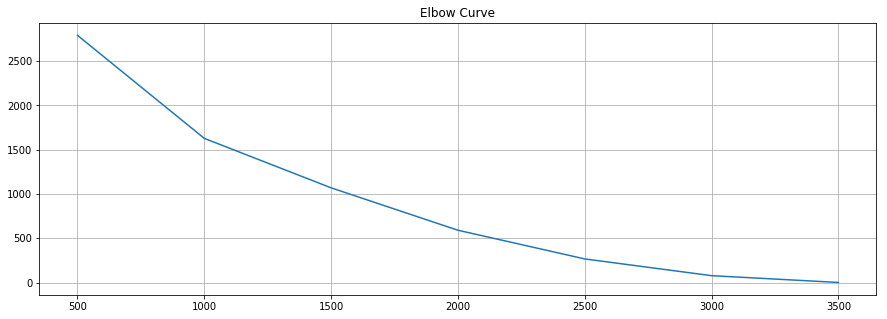

In [6]:
fig = plt.figure(figsize=(15, 5))
plt.plot(distorsions.keys(), distorsions.values())
plt.title('Elbow Curve')
plt.grid(True)

In [23]:
# best K = 3500
k = 3500
model = KMeans(n_clusters=k)
model.fit(tfidf)
print("k:", k, " cost:", model.inertia_)

k: 3500  cost: 1.35397156442036


#### Select top-n skus for each cluster

In [24]:
# create 'cluster' column
train['cluster'] = model.predict(vectorizer.transform(list(train['query'])))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
top_n = 5
m = pd.crosstab(train['cluster'], train['sku'])
train_top = pd.DataFrame({n: m.T[column].nlargest(top_n).index.tolist() for n, column in enumerate(m.T)}).T

In [26]:
train_top

,0,1,2,3,4
0,2541184,1004622,1010544,1011067,1011491
1,2467183,9854804,2107458,2467129,1004622
2,2173065,3046603,9927328,2467129,2703101
3,2945052,2670133,2107458,9889193,2856517
4,2107458,3668336,3001046,2953607,3046603
5,9854804,2467129,2467183,2670133,2856517
6,2670133,2945052,2107458,9889193,2078113
7,2953607,2078113,3001046,2467129,2856517
8,2633103,2633149,3046066,2212043,3432088
9,2704058,2670133,2375195,2467129,2541184


#### Test model on test dataset

In [27]:
# create 'cluster' column
test['cluster'] = model.predict(vectorizer.transform(list(test['query'])))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
# get the top sku for each cluster
predictions = pd.DataFrame(train_top.iloc[test['cluster']])
predictions = predictions.rename(index=str, columns={0: "sku"})

In [29]:
predictions

,sku,1,2,3,4
2,2173065,3046603,9927328,2467129,2703101
29,2807036,2704058,2375195,2727253,2842639
11,2977637,3046603,1032361,2032076,2173065
12,2173065,3046603,2467129,2953607,3001046
7,2953607,2078113,3001046,2467129,2856517
1688,3046603,1004622,1010544,1011067,1011491
59,2749041,2856517,2856544,1475036,2095189
4,2107458,3668336,3001046,2953607,3046603
188,1816073,2107458,3046603,1004622,1010544
14,9902347,2078113,9854804,9713872,2107458


In [30]:
# check result
number_of_matched_skus = 0
for test_sku, pred_sku in zip(test.sku, predictions.sku):
    if test_sku == pred_sku:
        number_of_matched_skus += 1
        
print('matched: ' + str(round(number_of_matched_skus / len(test) * 100, 2)) + '%')

matched: 64.59%
